In [16]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\edwar\AppData\Local\Temp\ipykernel_61204\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [18]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("../data/kg_train.csv",encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)

(1000, 2)


### Let's divide the training and test set into two partitions

In [19]:
# Your code
# Let's divide the training and test set into two partitions
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80-20 split)
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

# Print the shapes to verify the split
print("Training set shape:", data_train.shape)
print("Validation set shape:", data_val.shape)

Training set shape: (800, 2)
Validation set shape: (200, 2)


In [20]:
data_train

,text,label
29,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",1
535,I have not been able to reach oscar this am. W...,0
695,; Huma Abedin B6I'm checking with Pat on the 5...,0
557,I can have it announced here on Monday - can't...,0
836,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...,1
...,...,...
106,7653 2612ADAMA IBRAHIM________________________...,1
270,What does that mean for our schedules?,0
860,"Dear Friend,My Compliment to you,I guess this ...",1
435,Dear PRESIDENT=2FDIRECTOR=2C My name is Mr=2E ...,1


## Data Preprocessing

Let me explain what the SnowballStemmer is doing in this NLP context.
The SnowballStemmer is a text normalization tool that performs stemming - a process of reducing words to their root or base form (stem). However, it's different from lemmatization in that it follows a more aggressive set of rules and simply chops off word endings.
Here are some examples of what SnowballStemmer does:
"running" → "run"
"fishing" → "fish"
"played", "playing", "plays" → "play"
"connection", "connected", "connecting" → "connect"


In [21]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [22]:
# Your code
import re

def clean_html(text):
    # Remove inline JavaScript/CSS
    text = re.sub(r'<script.*?>.*?</script>', '', text, flags=re.DOTALL)
    text = re.sub(r'<style.*?>.*?</style>', '', text, flags=re.DOTALL)
    
    # Remove HTML comments
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    
    # Remove remaining HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    return text

# Apply the cleaning to both training and validation sets
data_train['text'] = data_train['text'].apply(clean_html)
data_val['text'] = data_val['text'].apply(clean_html)

# Display a sample to verify the cleaning
print("Sample cleaned text:")
print(data_train['text'].iloc[0])

Sample cleaned text:
----------- REGARDS, MR NELSON SMITH.KINDLY REPLY ME ON MY PRIVATE EMAIL ADDRESS;nelsonsmith2000@yahoo.com


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [23]:
# Your code
def improved_clean_text(text):
    # Convert to lowercase and handle encoding
    text = str(text).lower().encode('ascii', 'ignore').decode()
    
    # First, replace common encoding artifacts
    text = re.sub(r'â|ã¢|â€|œ|š', ' ', text)
    
    # Handle email addresses before general cleaning
    # Replace @ and . in emails with placeholder
    text = re.sub(r'([a-z0-9]+)[@.]([a-z0-9]+)', r'\1 at \2', text)
    
    # Replace punctuation with spaces
    for punct in string.punctuation:
        text = text.replace(punct, ' ')
    
    # Remove numbers but keep space between words
    text = re.sub(r'\d+', ' ', text)
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove standalone single characters except 'a' and 'i'
    words = text.split()
    words = [word for word in words if len(word) > 1 or word in ['a', 'i']]
    
    # Join words back together
    text = ' '.join(words)
    
    # Strip any leading/trailing spaces
    text = text.strip()
    
    return text

# Apply improved cleaning
print("Cleaning the text...")
data_train['clean_text'] = data_train['text'].apply(improved_clean_text)
data_val['clean_text'] = data_val['text'].apply(improved_clean_text)

Cleaning the text...


def improved_clean_text(text):
    # Convert to lowercase and handle encoding
    text = str(text).lower().encode('ascii', 'ignore').decode()
    
    # First, replace common encoding artifacts
    text = re.sub(r'â|ã¢|â€|œ|š', ' ', text)
    
    # Handle email addresses before general cleaning
    # Replace @ and . in emails with placeholder
    text = re.sub(r'([a-z0-9]+)[@.]([a-z0-9]+)', r'\1 at \2', text)
    
    # Replace punctuation with spaces
    for punct in string.punctuation:
        text = text.replace(punct, ' ')
    
    # Remove numbers but keep space between words
    text = re.sub(r'\d+', ' ', text)
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove standalone single characters except 'a' and 'i'
    words = text.split()
    words = [word for word in words if len(word) > 1 or word in ['a', 'i']]
    
    # Join words back together
    text = ' '.join(words)
    
    # Strip any leading/trailing spaces
    text = text.strip()
    
    return text

# Apply improved cleaning
print("Cleaning the text...")
data_train['clean_text'] = data_train['text'].apply(improved_clean_text)
data_val['clean_text'] = data_val['text'].apply(improved_clean_text)

#Your code
def clean_text(text):
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    # Replace punctuation with spaces BEFORE removing them
    # This ensures words don't get merged
    for punct in string.punctuation:
        text = text.replace(punct, ' ')
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove numbers but keep space between words
    text = re.sub(r'\d+', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-z]\s+', ' ', text)
    
    # Remove single characters from the start
    text = re.sub(r'^[a-z]\s+', '', text)
    
    # Strip any leading/trailing spaces
    text = text.strip()
    
    return text

# Apply the improved cleaning to both training and validation sets
data_train['clean_text'] = data_train['text'].apply(clean_text)
data_val['clean_text'] = data_val['text'].apply(clean_text)

# Let's check an example
print("BEFORE CLEANING:")
print(data_train['text'].iloc[0])
print("\nAFTER IMPROVED CLEANING:")
print(data_train['clean_text'].iloc[0])

## Now let's work on removing stopwords
Remove the stopwords.

In [24]:
# Your code
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    # Split text into words
    words = text.split()
    # Keep only non-stopwords
    filtered_words = [word for word in words if word not in stop_words]
    # Join words back together
    return ' '.join(filtered_words)

# Apply stopword removal to the clean_text column
data_train['clean_text'] = data_train['clean_text'].apply(remove_stopwords)
data_val['clean_text'] = data_val['clean_text'].apply(remove_stopwords)

# Let's see the difference
print("BEFORE STOPWORD REMOVAL:")
print(data_train['text'].iloc[0])
print("\nAFTER ALL CLEANING AND STOPWORD REMOVAL:")
print(data_train['clean_text'].iloc[0])

BEFORE STOPWORD REMOVAL:
----------- REGARDS, MR NELSON SMITH.KINDLY REPLY ME ON MY PRIVATE EMAIL ADDRESS;nelsonsmith2000@yahoo.com

AFTER ALL CLEANING AND STOPWORD REMOVAL:
regards mr nelson smith kindly reply private email address nelsonsmith yahoo com


## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [25]:
# Your code
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk

# Download required NLTK data if you haven't already
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the words back together
    return ' '.join(lemmatized_words)

# Apply lemmatization to the clean_text column
data_train['clean_text'] = data_train['clean_text'].apply(lemmatize_text)
data_val['clean_text'] = data_val['clean_text'].apply(lemmatize_text)

# Let's see an example of the transformation
print("BEFORE LEMMATIZATION:")
print(data_train['text'].iloc[0])
print("\nAFTER ALL CLEANING AND LEMMATIZATION:")
print(data_train['clean_text'].iloc[0])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edwar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\edwar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\edwar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


BEFORE LEMMATIZATION:
----------- REGARDS, MR NELSON SMITH.KINDLY REPLY ME ON MY PRIVATE EMAIL ADDRESS;nelsonsmith2000@yahoo.com

AFTER ALL CLEANING AND LEMMATIZATION:
regard mr nelson smith kindly reply private email address nelsonsmith yahoo com


## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

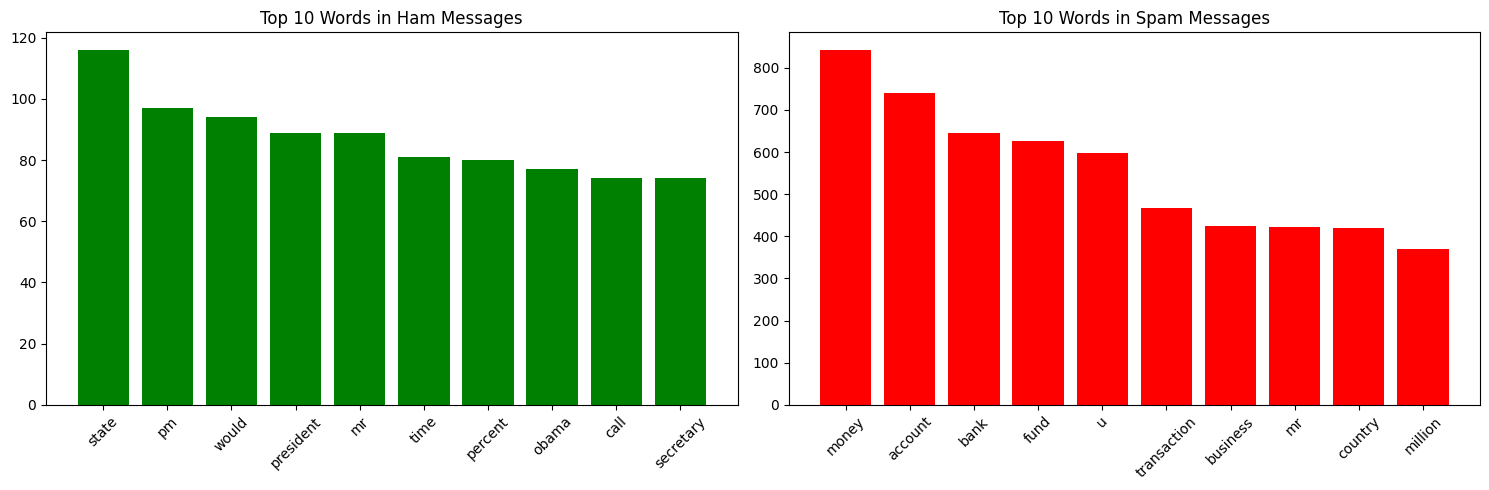


Top 10 words in Ham messages:
state: 116
pm: 97
would: 94
president: 89
mr: 89
time: 81
percent: 80
obama: 77
call: 74
secretary: 74

Top 10 words in Spam messages:
money: 842
account: 740
bank: 645
fund: 625
u: 598
transaction: 466
business: 424
mr: 422
country: 419
million: 369


In [26]:
# Your code
from collections import Counter
import matplotlib.pyplot as plt

# Function to get word frequencies
def get_word_freq(texts):
    # Combine all texts into one list of words
    all_words = ' '.join(texts).split()
    # Count word frequencies
    return Counter(all_words)

# Separate ham and spam messages
ham_messages = data_train[data_train['label'] == 0]['clean_text']
spam_messages = data_train[data_train['label'] == 1]['clean_text']

# Get word frequencies for both
ham_word_freq = get_word_freq(ham_messages)
spam_word_freq = get_word_freq(spam_messages)

# Get top 10 words for each
ham_top_10 = dict(sorted(ham_word_freq.items(), key=lambda x: x[1], reverse=True)[:10])
spam_top_10 = dict(sorted(spam_word_freq.items(), key=lambda x: x[1], reverse=True)[:10])

# Create subplots for visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot ham words
ax1.bar(ham_top_10.keys(), ham_top_10.values(), color='green')
ax1.set_title('Top 10 Words in Ham Messages')
ax1.tick_params(axis='x', rotation=45)

# Plot spam words
ax2.bar(spam_top_10.keys(), spam_top_10.values(), color='red')
ax2.set_title('Top 10 Words in Spam Messages')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print the frequencies
print("\nTop 10 words in Ham messages:")
for word, count in ham_top_10.items():
    print(f"{word}: {count}")

print("\nTop 10 words in Spam messages:")
for word, count in spam_top_10.items():
    print(f"{word}: {count}")

## Extra features

In [27]:
# Define our patterns
money_simbol_list = "|".join(["euro","dollar","pound","€","$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

# Add features using 'clean_text' instead of 'preprocessed_text'
data_train['money_mark'] = data_train['clean_text'].str.contains(money_simbol_list)*1
data_train['suspicious_words'] = data_train['clean_text'].str.contains(suspicious_words)*1
data_train['text_len'] = data_train['clean_text'].apply(lambda x: len(x)) 

# Do the same for validation set
data_val['money_mark'] = data_val['clean_text'].str.contains(money_simbol_list)*1
data_val['suspicious_words'] = data_val['clean_text'].str.contains(suspicious_words)*1
data_val['text_len'] = data_val['clean_text'].apply(lambda x: len(x)) 

# Let's see what we got
print("\nSample of the new features:")
print(data_train[['clean_text', 'money_mark', 'suspicious_words', 'text_len']].head())

# Print some statistics
print("\nStatistics of new features:")
print("\nMoney marks found:", data_train['money_mark'].sum())
print("Suspicious words found:", data_train['suspicious_words'].sum())
print("Average text length:", data_train['text_len'].mean())


Sample of the new features:
                                            clean_text  money_mark  \
29   regard mr nelson smith kindly reply private em...           1   
535         able reach oscar supposed send pdb receive           1   
695  huma abedin checking pat work jack jake rest a...           1   
557                             announced monday today           1   
836  bank africaagence san pedro bp san pedro cote ...           1   

     suspicious_words  text_len  
29                  0        79  
535                 0        42  
695                 0        76  
557                 0        22  
836                 1      1050  

Statistics of new features:

Money marks found: 800
Suspicious words found: 355
Average text length: 963.03875


# We add to the original dataframe two additional indicators (money symbols and suspicious words).
money_simbol_list = "|".join(["euro","dollar","pound","€",r"\$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

data_train['money_mark'] = data_train['preprocessed_text'].str.contains(money_simbol_list)*1
data_train['suspicious_words'] = data_train['preprocessed_text'].str.contains(suspicious_words)*1
data_train['text_len'] = data_train['preprocessed_text'].apply(lambda x: len(x)) 

data_val['money_mark'] = data_val['preprocessed_text'].str.contains(money_simbol_list)*1
data_val['suspicious_words'] = data_val['preprocessed_text'].str.contains(suspicious_words)*1
data_val['text_len'] = data_val['preprocessed_text'].apply(lambda x: len(x)) 

data_train.head()

## How would work the Bag of Words with Count Vectorizer concept?

In [28]:
# Your code
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
# We'll set some parameters:
# - max_features: limit to top 1000 most frequent words
# - min_df: ignore words that appear in less than 2 documents
# - max_df: ignore words that appear in more than 90% of documents
vectorizer = CountVectorizer(max_features=1000, min_df=2, max_df=0.9)

# Fit and transform the training data
X_train_bow = vectorizer.fit_transform(data_train['clean_text'])

# Transform the validation data (only transform, not fit)
X_val_bow = vectorizer.transform(data_val['clean_text'])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Look at the vocabulary and some statistics
print("Vocabulary size:", len(feature_names))
print("\nFirst 20 words in vocabulary:")
print(feature_names[:20])

# Show the shape of our transformed data
print("\nShape of training data:", X_train_bow.shape)
print("Shape of validation data:", X_val_bow.shape)

# Let's look at the first document's word counts
first_doc = X_train_bow[0].toarray()[0]
words_freq = [(word, count) for word, count in zip(feature_names, first_doc) if count > 0]
sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)

print("\nTop 10 words in first document:")
for word, count in sorted_words[:10]:
    print(f"{word}: {count}")

Vocabulary size: 1000

First 20 words in vocabulary:
['ab' 'abacha' 'abandoned' 'abidjan' 'able' 'abroad' 'ac' 'accept'
 'acceptance' 'access' 'accord' 'according' 'account' 'accounting'
 'across' 'act' 'action' 'actual' 'actually' 'ad']

Shape of training data: (800, 1000)
Shape of validation data: (200, 1000)

Top 10 words in first document:
address: 1
com: 1
email: 1
kindly: 1
mr: 1
private: 1
regard: 1
reply: 1
smith: 1
yahoo: 1


The Bag of Words approach is useful because:
It converts text into numerical features that machine learning models can use
It preserves word frequency information
It's simple but effective for many text classification tasks

## TF-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [29]:
# Your code
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
# Similar parameters to CountVectorizer for consistency
tfidf_vectorizer = TfidfVectorizer(max_features=1000, 
                                  min_df=2, 
                                  max_df=0.9)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(data_train['clean_text'])

# Transform the validation data
X_val_tfidf = tfidf_vectorizer.transform(data_val['clean_text'])

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print information about the vectorized dataset
print("Vocabulary size:", len(feature_names))
print("\nShape of training set:", X_train_tfidf.shape)
print("Shape of validation set:", X_val_tfidf.shape)

# Let's look at some of the features and their TF-IDF scores
# Get the first document's features
first_doc = X_train_tfidf[0]

# Create a list of (word, tfidf_score) pairs for non-zero entries
tfidf_scores = [(feature_names[i], first_doc[0, i]) 
                for i in first_doc.nonzero()[1]]

# Sort by TF-IDF score
sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

print("\nTop 10 words by TF-IDF score in first document:")
for word, score in sorted_scores[:10]:
    print(f"{word}: {score:.4f}")

Vocabulary size: 1000

Shape of training set: (800, 1000)
Shape of validation set: (200, 1000)

Top 10 words by TF-IDF score in first document:
smith: 0.4996
kindly: 0.3625
yahoo: 0.3330
com: 0.3082
reply: 0.2825
private: 0.2715
address: 0.2664
email: 0.2650
regard: 0.2616
mr: 0.2233


The main difference between TF-IDF and Bag of Words is:
Bag of Words just counts word occurrences
TF-IDF weighs words based on how important they are:
Common words in a document get higher TF (Term Frequency)
Words that appear in many documents get lower IDF (Inverse Document Frequency)
This helps identify distinctive words that are important for classification

## And the Train a Classifier?

Training Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       433
           1       0.98      0.97      0.98       367

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       125
           1       0.95      0.96      0.95        75

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.97      0.96      0.97       200



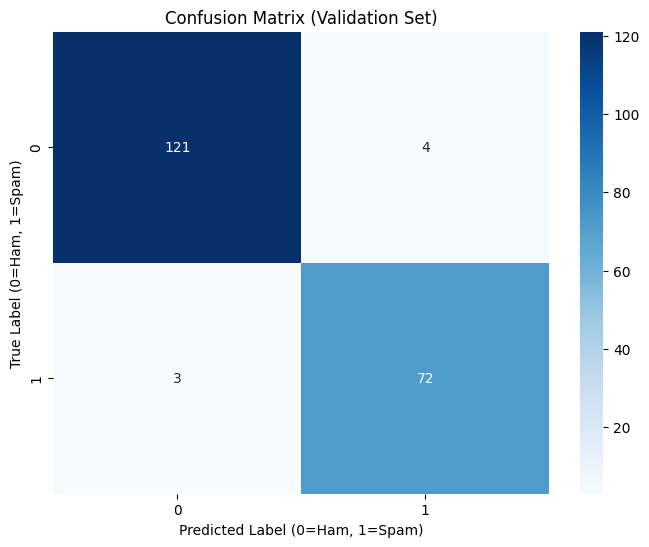


Example Predictions:

Text: dear sir wish go offer consider partner ei mr esamson bamogu cfrom republic sierra leone west africa...
True Label: Spam
Predicted Label: Spam

Text: take mind balkan second see great plug global entrepreneurship program whichlorraine hariton steve k...
True Label: Ham
Predicted Label: Ham

Text: pls keep update coming...
True Label: Ham
Predicted Label: Ham

Text: christ bethel hospital rue abobote abidjanivory coast dearest beloved sister anita adam johnson ivor...
True Label: Spam
Predicted Label: Spam

Text: sbwhoeopfriday february amhre bravo brava issue statement sidwill find invite uk irish ambassador st...
True Label: Ham
Predicted Label: Ham

Top spam-indicating words:
bank: 2.5290
fund: 2.5099
money: 2.5031
account: 2.4904
transaction: 2.3157
transfer: 2.1030
kin: 1.9668
nbsp: 1.9008
dollar: 1.8359
million: 1.8211

Top ham-indicating words:
fyi: -4.2904
cheryl: -3.1251
tomorrow: -3.0986
ok: -2.9308
pm: -2.7625
gov: -2.6517
print: -2.5401
pls: -2.5

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Initialize and train the classifier
clf = MultinomialNB()
clf.fit(X_train_tfidf, data_train['label'])

# 2. Make predictions
train_predictions = clf.predict(X_train_tfidf)
val_predictions = clf.predict(X_val_tfidf)

# 3. Evaluate the model
print("Training Set Performance:")
print(classification_report(data_train['label'], train_predictions))
print("\nValidation Set Performance:")
print(classification_report(data_val['label'], val_predictions))

# 4. Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(data_val['label'], val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('True Label (0=Ham, 1=Spam)')
plt.xlabel('Predicted Label (0=Ham, 1=Spam)')
plt.show()

# 5. Print some example predictions
print("\nExample Predictions:")
for i in range(5):
    text = data_val['clean_text'].iloc[i]
    true_label = data_val['label'].iloc[i]
    pred_label = clf.predict(X_val_tfidf[i])[0]
    
    print(f"\nText: {text[:100]}...")  # Show first 100 characters
    print(f"True Label: {'Spam' if true_label == 1 else 'Ham'}")
    print(f"Predicted Label: {'Spam' if pred_label == 1 else 'Ham'}")

# 6. Print feature importance using probability estimates instead
feature_names = tfidf_vectorizer.get_feature_names_out()
# Get probability estimates for spam class
probs = clf.feature_log_prob_[1] - clf.feature_log_prob_[0]
top_spam_idx = np.argsort(probs)[-10:]  # Top 10 spam features
top_ham_idx = np.argsort(probs)[:10]    # Top 10 ham features

print("\nTop spam-indicating words:")
for idx in reversed(top_spam_idx):
    print(f"{feature_names[idx]}: {probs[idx]:.4f}")

print("\nTop ham-indicating words:")
for idx in top_ham_idx:
    print(f"{feature_names[idx]}: {probs[idx]:.4f}")

### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to **find the most relevant features**.

For example, you can test the following options and check which of them performs better:
- Using "Bag of Words" only
- Using "TF-IDF" only
- Bag of Words + extra flags (money_mark, suspicious_words, text_len)
- TF-IDF + extra flags


You can work with teams of two persons (recommended).

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import numpy as np

def evaluate_model(X_train, X_val, y_train, y_val):
    # Initialize and train classifier (must use MultinomialNB with default parameters)
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    
    # Make predictions
    val_pred = clf.predict(X_val)
    
    # Return validation score
    return classification_report(y_val, val_pred)

# 1. Basic TF-IDF with different parameters
tfidf_basic = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.9)
X_train_basic = tfidf_basic.fit_transform(data_train['clean_text'])
X_val_basic = tfidf_basic.transform(data_val['clean_text'])

print("Basic TF-IDF Performance:")
print(evaluate_model(X_train_basic, X_val_basic, data_train['label'], data_val['label']))

# 2. TF-IDF with character n-grams
tfidf_chars = TfidfVectorizer(analyzer='char', ngram_range=(3,5), max_features=1000)
X_train_chars = tfidf_chars.fit_transform(data_train['clean_text'])
X_val_chars = tfidf_chars.transform(data_val['clean_text'])

print("\nCharacter N-grams Performance:")
print(evaluate_model(X_train_chars, X_val_chars, data_train['label'], data_val['label']))

# 3. TF-IDF with word n-grams
tfidf_words = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
X_train_words = tfidf_words.fit_transform(data_train['clean_text'])
X_val_words = tfidf_words.transform(data_val['clean_text'])

print("\nWord N-grams Performance:")
print(evaluate_model(X_train_words, X_val_words, data_train['label'], data_val['label']))

# 4. Combine TF-IDF features with additional features
from scipy.sparse import hstack

# Create additional features
def get_extra_features(texts):
    features = np.zeros((len(texts), 4))
    for i, text in enumerate(texts):
        features[i, 0] = len(text)  # Text length
        features[i, 1] = text.count('!')  # Count exclamations
        features[i, 2] = sum(1 for c in text if c.isupper())  # Count uppercase
        features[i, 3] = len(text.split())  # Word count
    return features

# Get extra features for both sets
train_extra = get_extra_features(data_train['clean_text'])
val_extra = get_extra_features(data_val['clean_text'])

# Combine with best performing TF-IDF features
X_train_combined = hstack([X_train_words, train_extra])
X_val_combined = hstack([X_val_words, val_extra])

print("\nCombined Features Performance:")
print(evaluate_model(X_train_combined, X_val_combined, data_train['label'], data_val['label']))

# Print best performing approach
print("\nBest performing feature representation can be used for the Kaggle submission!")

Basic TF-IDF Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       125
           1       0.95      0.96      0.95        75

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.97      0.96      0.97       200


Character N-grams Performance:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       125
           1       0.92      0.91      0.91        75

    accuracy                           0.94       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.94      0.93       200


Word N-grams Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       125
           1       0.95      0.96      0.95        75

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96